# Notebook configuration

In [1]:
run_number    = 4446
save_plots    = False
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "run{}_corrections.h5".format(run_number)
inputfilename = "/Users/Gonzalo/github/NEXTdata/Kr/dst_{}.root.h5".format(run_number)

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Prange        =  -3.2, 3.2  
Erange_raw    =     0, 15e3
Erange_zcorr  =   5e3, 15e3
Erange_xycorr =   9e3, 14e3
Erange_fit    = 11500, 14e3
Qrange        =     0, 10e2
QErange       =     0, Qrange[1]/Erange_xycorr[1]
Frange        =   0.8, 1.5
Urange        =  1e-3, 1.2e-2

S1Erange      =     0, 40
S1Wrange      =     0, 400
S1Hrange      =     0, 10
S2Wrange      =     0, 50
S2Hrange      =     0, 10e3
NSirange      =     0, 30

Zrange_LT     =    50, 520
Zrange_XY     =     0, 520
nX, nY, nR    =    50,  50, 50
x0, y0, r0    =    40, -40, 15 # for lifetime scan

extra_pitches = [( 25,  25),
                 ( 50,  50),
                 ( 75,  75),
                 (100, 100)]

LT_radial     = False
split_sample  = True

In [2]:
Emin_fit      = Erange_fit[0]
Emax_fit      = Erange_fit[1]
Emean_fit     = 0.5*sum(Erange_fit)

In [3]:
def poisson_sigma(x, default=3):
    u = x**0.5
    u[x==0] = default
    return u

# Kr analysis

In [4]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .kdst_io        as dstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Fri Jul 28 18:32:15 2017


#### General plotting options

In [5]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [6]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

2313998


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,3,1.498855e+09,0,1,225.0,8.846622,52.280453,103125.0,13.354375,1026.412231,...,653837.5,6,550.7125,550.7125,-63.594418,-16.808640,65.778267,-2.883192,6.368430,6.604301
1,4,1.498855e+09,0,1,350.0,2.025267,15.240196,219275.0,12.262375,1504.927368,...,654112.5,9,434.8375,434.8375,92.378665,-49.306269,104.713542,-0.490275,7.859703,7.077931
2,5,1.498855e+09,0,1,150.0,1.761057,8.805047,507025.0,6.912687,2882.450928,...,652912.5,9,145.8875,145.8875,132.661609,-98.440055,165.195481,-0.638386,6.515345,7.052158
3,6,1.498855e+09,0,2,325.0,5.813896,30.049382,132700.0,11.003438,1026.416138,...,654262.5,6,521.5625,521.5625,99.314243,-40.558958,107.276968,-0.387718,4.970292,8.730874
4,6,1.498855e+09,1,2,325.0,5.813896,30.049382,132700.0,15.598875,1655.153320,...,681962.5,14,549.2625,549.2625,132.305139,-95.098586,162.936769,-0.623221,9.104363,9.883217


In [7]:
if split_sample:
    full_data  = full
    test_data  = full[::2]
    train_data = full[1::2] 

    full       = train_data

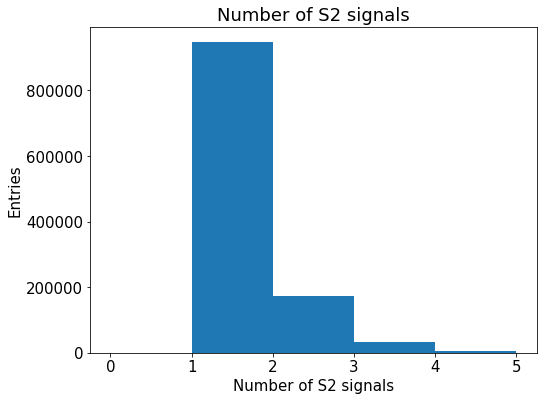

In [8]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

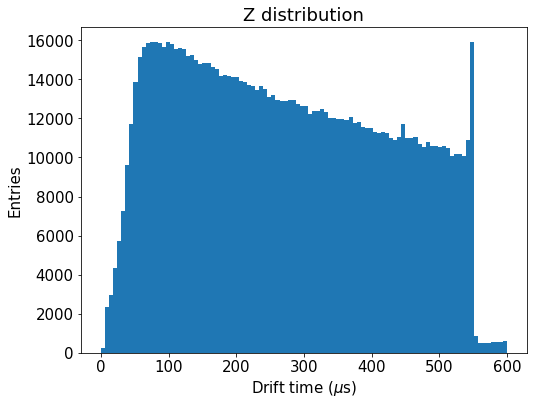

In [9]:
hist(full.Z, 100, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

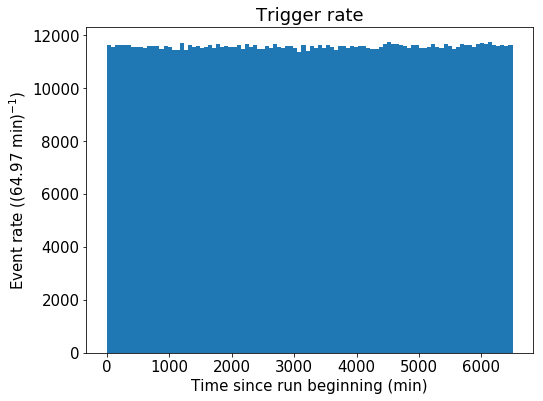

In [10]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _ = hist(T, 100, (np.min(T), np.max(T)))
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(x)[0]),
       "Trigger rate")
save("EventRate")

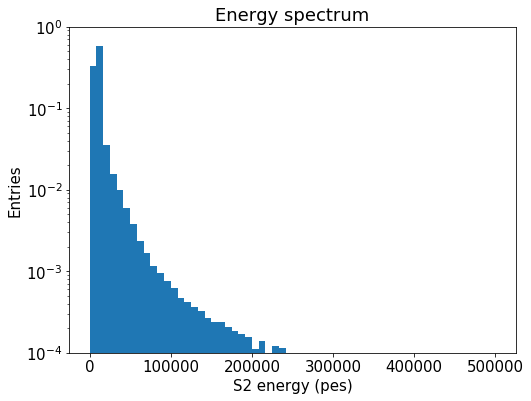

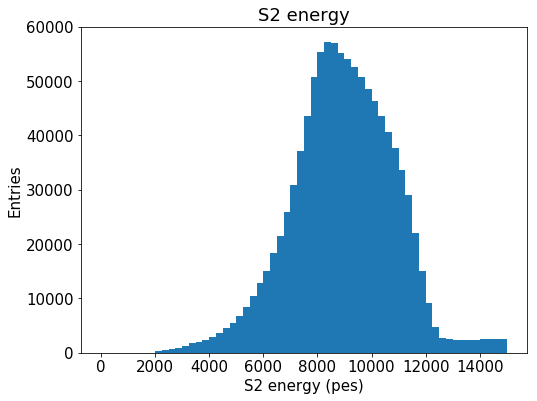

In [11]:
pdf(full.S2e, 60, (0, 500e3))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
save("Raw_energy_wide")

hist(full.S2e, 60, Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

# S1 energy

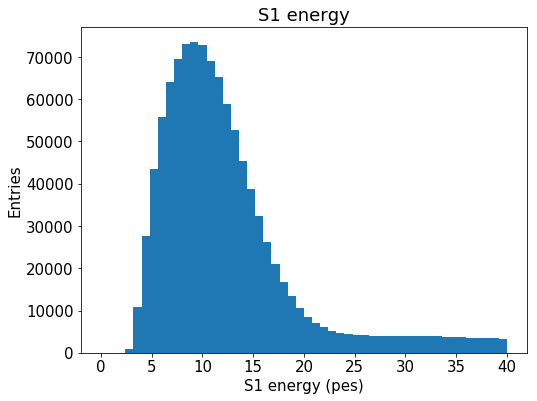

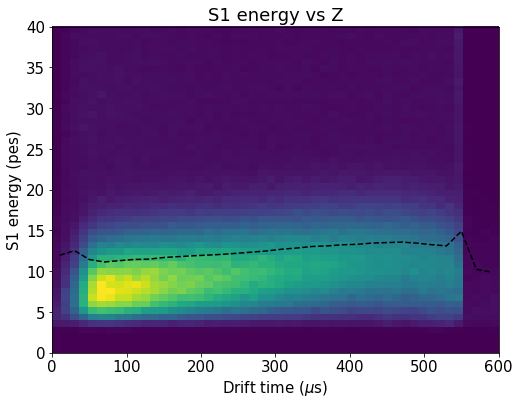

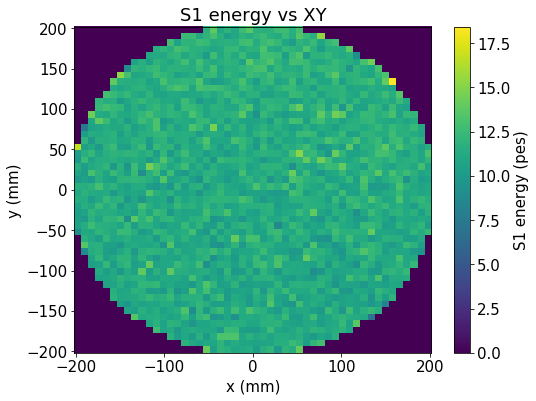

In [12]:
hist(full.S1e, 50, range=S1Erange)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(full.Z, full.S1e, (50, 50), range=(Zrange, S1Erange))
x, y, _ = fitf.profileX(full.Z, full.S1e, 30, xrange=Zrange, yrange=S1Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyvsZ")

short_drift = coref.in_range(full.Z  .values,   0,  100) &\
              coref.in_range(full.S1e.values, *S1Erange)

x, y, S, u_S = \
fitf.profileXY(full.X  .values[short_drift],
               full.Y  .values[short_drift],
               full.S1e.values[short_drift],
               nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, S)
cb.set_label("S1 energy (pes)")
labels("x (mm)", "y (mm)", "S1 energy vs XY")
save("S1energyvsXY")

# S1 width

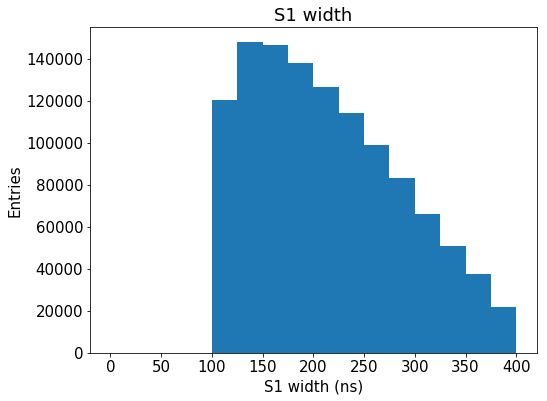

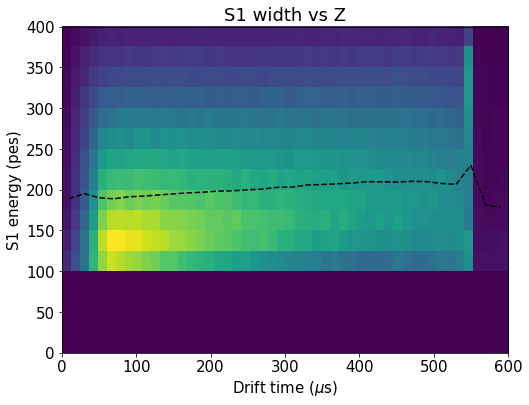

In [13]:
nb = max(S1Wrange)//25
hist(full.S1w, nb, S1Wrange)
labels("S1 width (ns)", "Entries", "S1 width")
save("S1width")

hist2d(full.Z, full.S1w, (50, nb), range=(Zrange, S1Wrange))
x, y, _ = fitf.profileX(full.Z, full.S1w, 30, xrange=Zrange, yrange=S1Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 width vs Z")
save("S1widthvsZ")

# S1 height

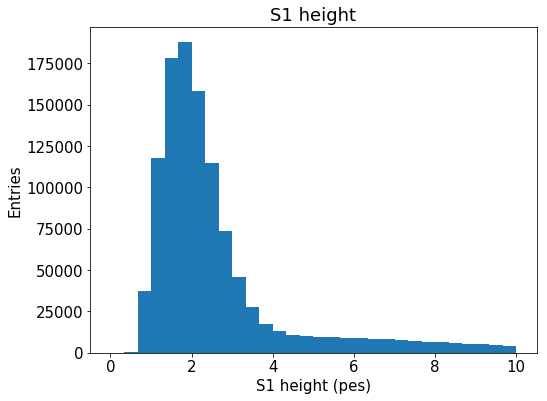

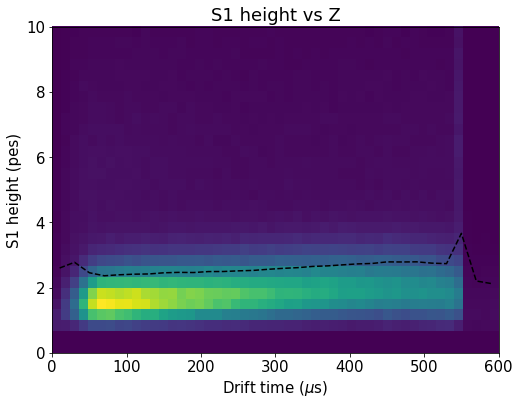

In [14]:
hist(full.S1h, 30, range=S1Hrange)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(full.Z, full.S1h, (50, 30), range=(Zrange, S1Hrange))
x, y, _ = fitf.profileX(full.Z, full.S1h, 30, xrange=Zrange, yrange=S1Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightvsZ")

# S1 peak to area ratio

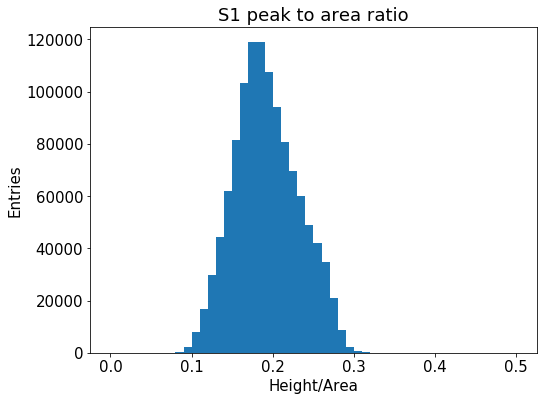

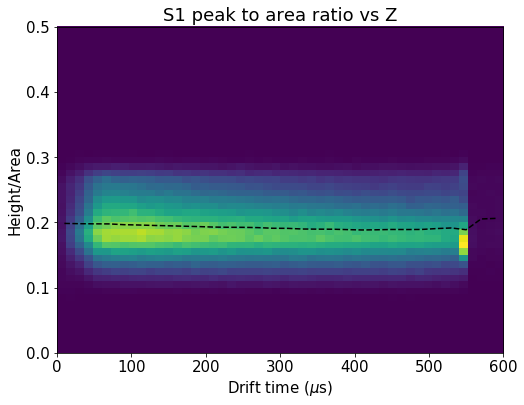

In [15]:
S1r    = full.S1h/full.S1e
_range = 0, 0.5

hist(S1r, 50, range=_range)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(full.Z, S1r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S1r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1Peak2AreavsZ")

# S2 energy

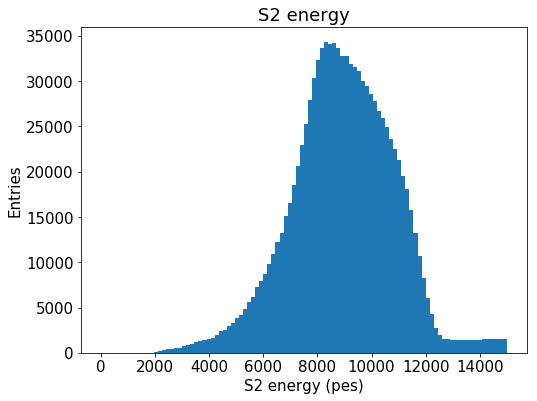

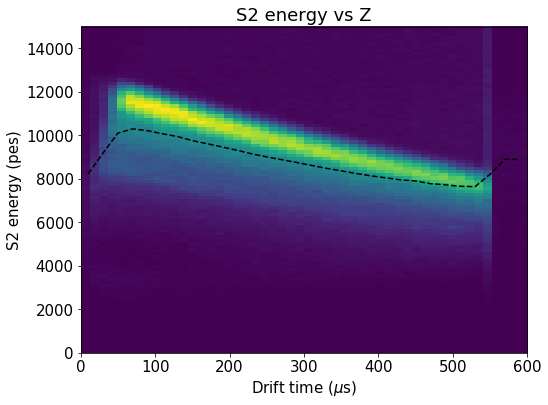

In [16]:
hist(full.S2e, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(Zrange, Erange_raw))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

# S2 width

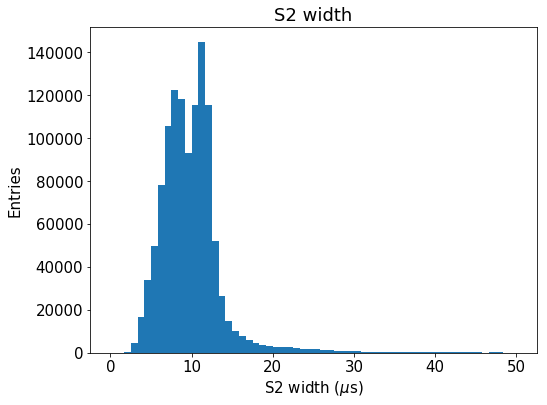

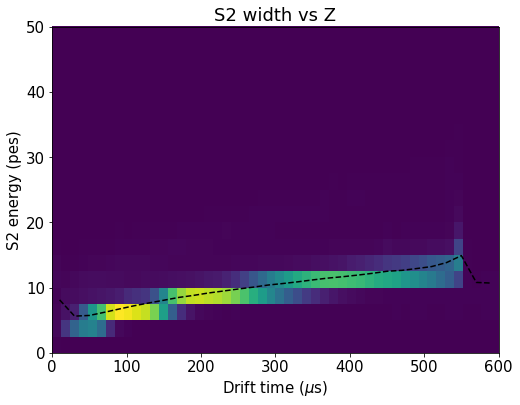

In [17]:
hist(full.S2w, 60, range=S2Wrange)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(full.Z, full.S2w, (50, 20), range=(Zrange, S2Wrange))
x, y, _ = fitf.profileX(full.Z, full.S2w, 30, xrange=Zrange, yrange=S2Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 width vs Z")
save("S2widthvsZ")

# S2 height

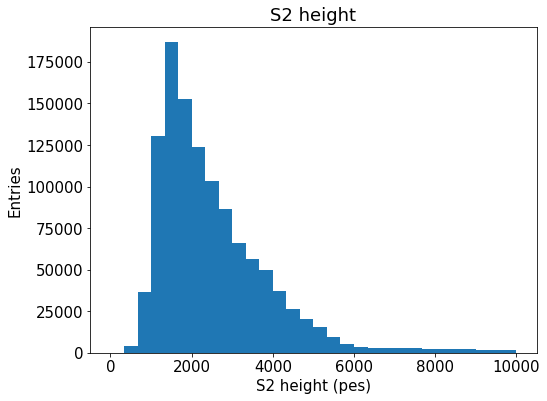

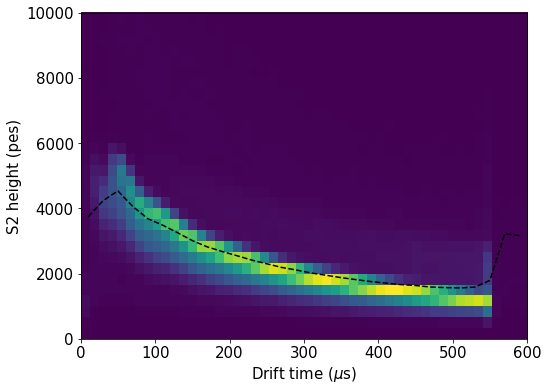

In [18]:
hist(full.S2h, 30, range=S2Hrange)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(full.Z, full.S2h, (50, 30), range=(Zrange, S2Hrange))
x, y, _ = fitf.profileX(full.Z, full.S2h, 30, xrange=Zrange, yrange=S2Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

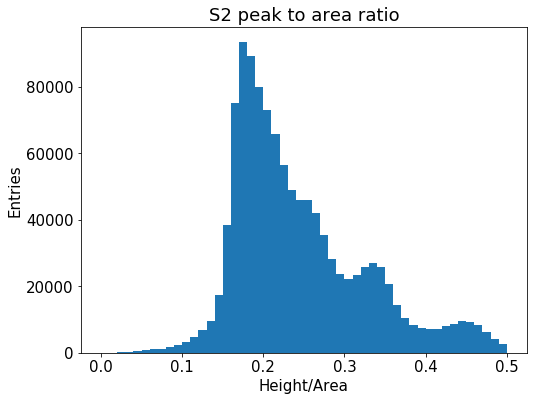

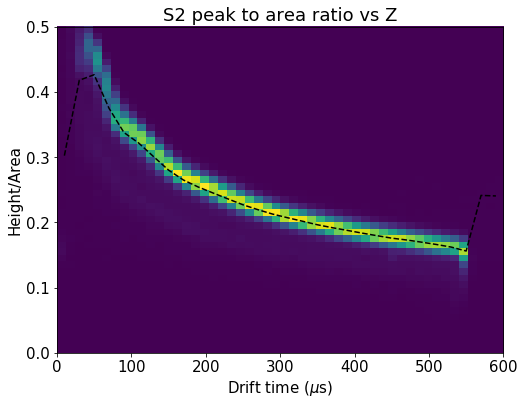

In [19]:
_range = 0, 0.5

S2r = full.S2h/full.S2e

hist(S2r, 50, range=_range)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(full.Z, S2r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S2r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2Peak2AreavsZ")

# S2 vs S1

[  3.53917126e+01   3.31673259e+06] [[ -9.99999954e-01   3.01700271e-04]
 [ -3.01700271e-04  -9.99999954e-01]]


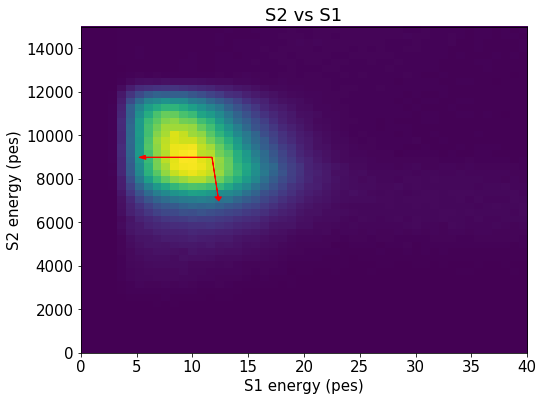

In [20]:
hist2d(full.S1e, full.S2e, (50, 50), range=(S1Erange, Erange_raw))
#x, y, _ = fitf.profileX(full.S1e, full.S2e, 30, xrange=S1Erange, yrange=Erange_raw)
#plt.plot(x, y, profOpt)

sel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)
c = covariance(full[sel].S1e, full[sel].S2e)
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)", "S2 vs S1")
save("S2vsS1")

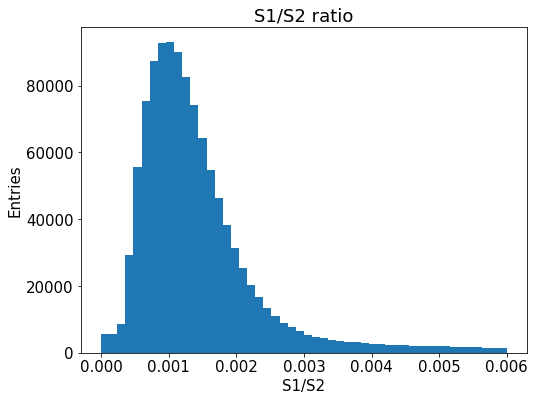

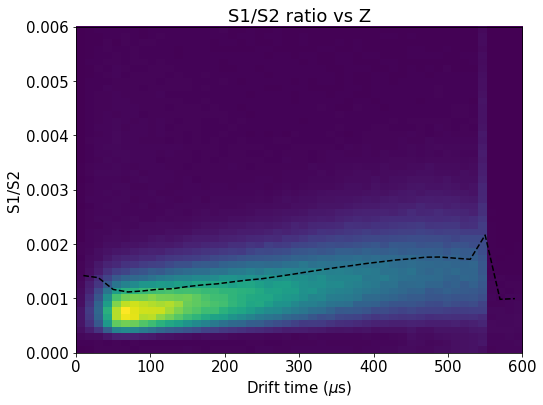

In [21]:
_range = 0, 0.006

S12r = full.S1e/full.S2e

hist(S12r, 50, range=_range)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(full.Z, S12r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S12r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratiovsZ")

# Lifetime calculation

In [22]:
fid = full
fid = fid[fid.R < 100] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.23229406421267434


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
21,28,1.498855e+09,0,1,100.0,2.614740,10.185054,416000.0,9.303062,2444.630371,...,652887.5,10,236.8875,236.8875,16.513884,-95.612896,97.028523,-1.399768,8.137515,7.025038
34,45,1.498855e+09,0,1,125.0,2.320742,10.095021,335675.0,10.063750,1878.922485,...,653112.5,11,317.4375,317.4375,-27.743764,-90.341372,94.505449,-1.868753,8.291966,7.955450
78,134,1.498855e+09,0,1,300.0,1.408665,11.553584,170150.0,12.234188,1327.791748,...,653862.5,9,483.7125,483.7125,-63.430972,15.079098,65.198676,2.908200,7.117684,9.121862
111,177,1.498855e+09,0,1,150.0,2.160993,10.327014,331100.0,10.890000,2107.463623,...,653262.5,12,322.1625,322.1625,-20.255540,-43.344829,47.844133,-2.007953,8.697399,8.241830
131,207,1.498855e+09,0,1,200.0,1.189534,4.740941,524400.0,6.029375,3472.430176,...,652937.5,10,128.5375,128.5375,22.746035,53.207305,57.865356,1.166811,6.924728,7.645361


# S2 energy fiducialized

Energy at z=0 = 12501.9 +- 5.2
Lifetime      = 1179.5 +- 2.1
Chi2          = 0.04          


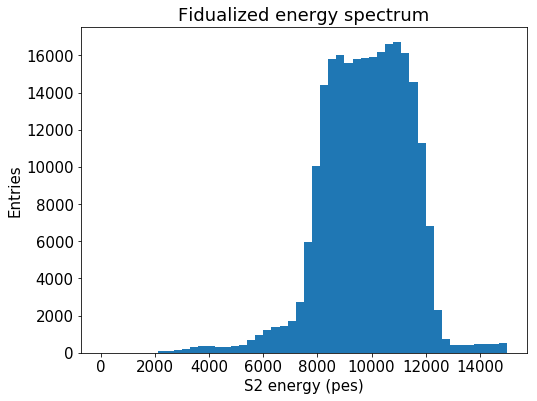

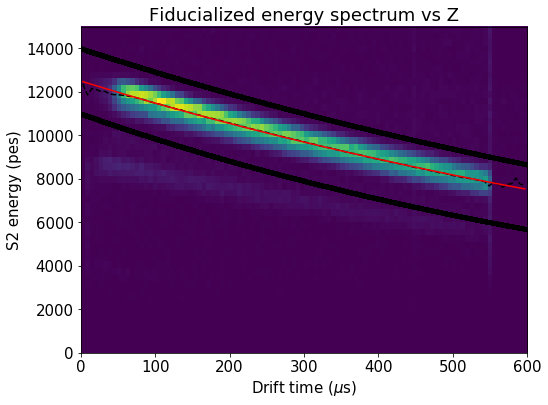

In [23]:
hist(fid.S2e, 50, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("Raw_energy_fiducial")

low_cut   = 11000 * np.exp(-0.0011*fid.Z.values)
high_cut  = 14000 * np.exp(-0.0008*fid.Z.values)
sel       = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(fid.Z, fid.S2e, (100, 50), range=(Zrange, Erange_raw))
x, y, u_y = fitf.profileX(fid.Z[sel], fid.S2e[sel], 100, xrange=Zrange, yrange=Erange_raw)

plt.plot(x, y, profOpt)
plt.plot(fid.Z.values,  low_cut, "k.")
plt.plot(fid.Z.values, high_cut, "k.")

seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("Raw_energy_vsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])

# Lifetime scan

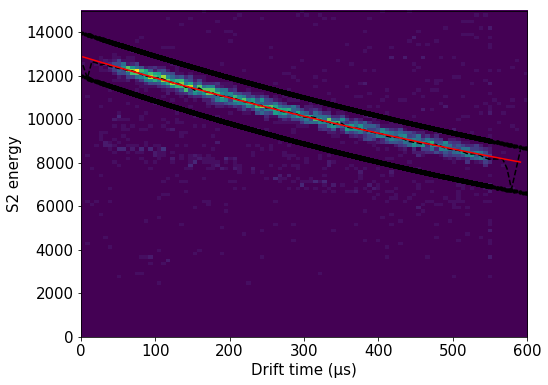

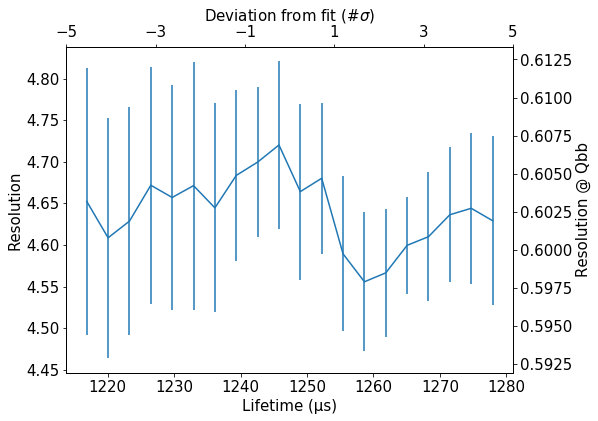

In [24]:
x0, y0, r0 = 40, -40, 15
sel  = ((full.X - x0)**2 +
        (full.Y - y0)**2) < r0**2
data = full[sel]

low_cut   = 12000 * np.exp(-0.0010*data.Z.values)
high_cut  = 14000 * np.exp(-0.0008*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

Z = data.Z  .values[sel]
E = data.S2e.values[sel]
x, y, u_y = fitf.profileX(Z, E, 100, xrange=Zrange, yrange=Erange_raw)
f = fitf.fit(fitf.expo, x, y, (13e3, -1e3), fit_range=(50, 400), sigma=u_y)

hist2d(data.Z, data.S2e, 100, (Zrange, Erange_raw))
plt.plot(x, y, profOpt)
plt.plot(x, f.fn(x),  fitOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

labels("Drift time (µs)", "S2 energy")


lts   = np.linspace(-f.values[1] - 5*f.errors[1],
                    -f.values[1] + 5*f.errors[1],
                    20)
sigs  = (lts + f.values[1]) / f.errors[1] 
res   = np.zeros_like(lts)
u_res = np.zeros_like(lts) 
for i in range(len(lts)):
    Ecorr    = E * np.exp(Z/lts[i])
    y, x     = np.histogram(Ecorr, 50, (11e3, 15e3))
    x        = shift_to_bin_centers(x)
    f        = fitf.fit(fitf.gauss, x, y, (1e5, 13e3, 1e2), fit_range=(12500, 13500), sigma=poisson_sigma(y))
    R        = resolution(f.values, f.errors)[0]
    res[i]   = R.value
    u_res[i] = R.uncertainty

plt.figure()
plt.errorbar(lts, res, u_res)
labels("Lifetime (µs)", "Resolution")

res_ticks = plt.yticks()[0]
xax = plt.gca().twiny()
yax = plt.gca().twinx()


xax.set_xlim(min(sigs), max(sigs))
xax.set_xticks(range(-5,6,2))
xax.set_xlabel("Deviation from fit (#$\sigma$)")

scale = (41.5/2458)**0.5
yax.set_ylim(min(res) * scale, max(res) * scale)
#yax.set_yticks(res_ticks * scale)
yax.set_ylabel("Resolution @ Qbb")

# Lifetime dependence

Lifetime =  (1235.6 +- 20.6) - (0.607 +- 0.167) x exp[x/(-1357614131.9 +- 1170041146525278.2)]
Chi2 = 0.848977831857


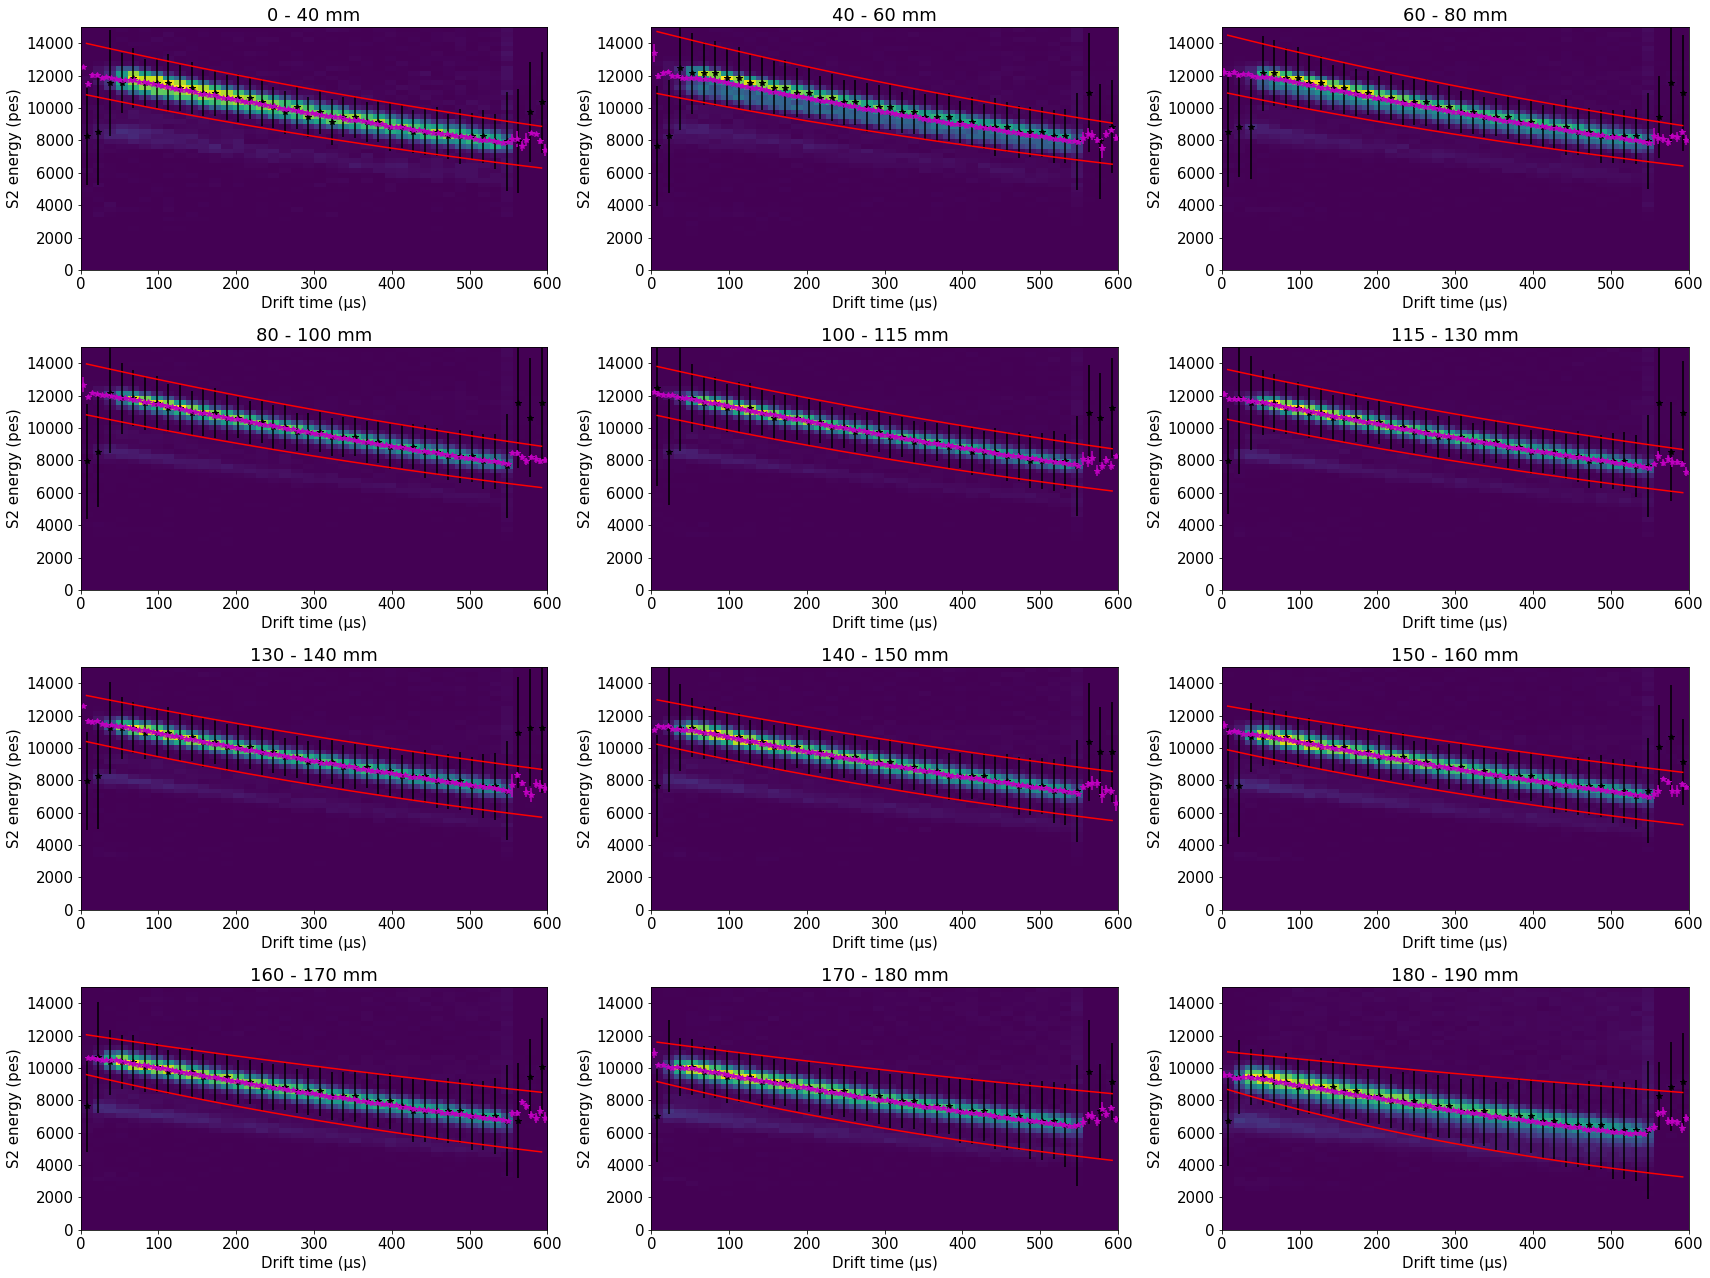

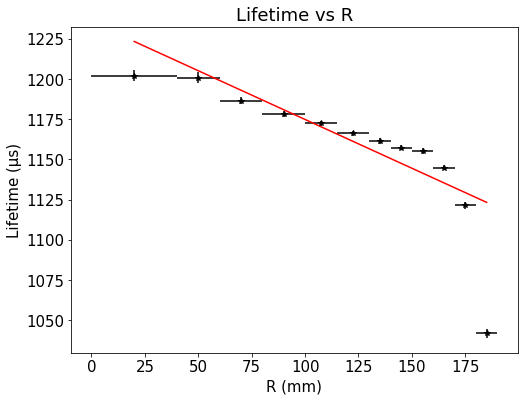

In [25]:
rbins  = np.array([0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190])
nbins  = len(rbins) - 1
nx, ny = 4, 3

LT     = np.zeros(nbins)
u_LT   = np.zeros(nbins)

Z = full.Z  .values
R = full.R  .values
E = full.S2e.values

plt.figure(figsize=(6*nx, 6*ny))

for i in range(nbins):
    sel_r = coref.in_range(E, *Erange_raw) & coref.in_range(R, *rbins[i:i+2])
    
    plt.subplot(nx, ny, i+1)
    n, x, y, _ = \
    hist2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw), new_figure=False)
    labels("Drift time (µs)", "S2 energy (pes)", "{:.0f} - {:.0f} mm".format(*rbins[i:i+2]))
    slice_max = np.argmax(n, axis=1)
    slice_ene = y[slice_max]
    slice_rms = [1.25*np.average((y-mean)**2, weights=w)**0.5 if np.any(w) else 0 for w, mean in zip(n, slice_ene)]
    
    plt.errorbar(x, slice_ene, slice_rms, fmt="*k")
    
    f_low = fitf.fit(fitf.expo, x, slice_ene-slice_rms, (1e4, -500), fit_range=Zrange_LT)
    f_upp = fitf.fit(fitf.expo, x, slice_ene+slice_rms, (1e4, -500), fit_range=Zrange_LT)
    
    plt.plot(x, f_low.fn(x), "r")
    plt.plot(x, f_upp.fn(x), "r")

    low_cut = f_low.fn(Z)
    upp_cut = f_upp.fn(Z)
    sel_E   = coref.in_range(E, low_cut, upp_cut) # remove low and high E background

    x, y, u_y = fitf.profileX(Z[sel_r & sel_E], E[sel_r & sel_E], 100, xrange=Zrange, yrange=Erange_raw)
    plt.errorbar(x, y, u_y, fmt="*m")

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    LT  [i] = -f.values[1]
    u_LT[i] =  f.errors[1]
plt.tight_layout()

dr    = np.diff(rbins) * 0.5
rbins = rbins[:-1] + dr 
plt.figure()
plt.errorbar(rbins, LT, u_LT, dr, fmt="k*")

seed = (LT[0], 1e-2, 100)
func = lambda x, a=0, b=0, c=0, d=0: a - b*x*np.exp(x/c)
f = fitf.fit(func, rbins, LT, seed, sigma=u_LT)
plt.plot(rbins, f.fn(rbins), "-r")
labels("R (mm)", "Lifetime (µs)", "Lifetime vs R")
save("LifetimevsR_profile")

print("Lifetime = ", "({0:.1f} +- {3:.1f}) - ({1:.3f} +- {4:.3f}) x exp[x/({2:.1f} +- {5:.1f})]".format(*f.values, *f.errors))
print("Chi2 =", f.chi2)
Zcorr_R = corrf.LifetimeRCorrection(f.values, f.errors)

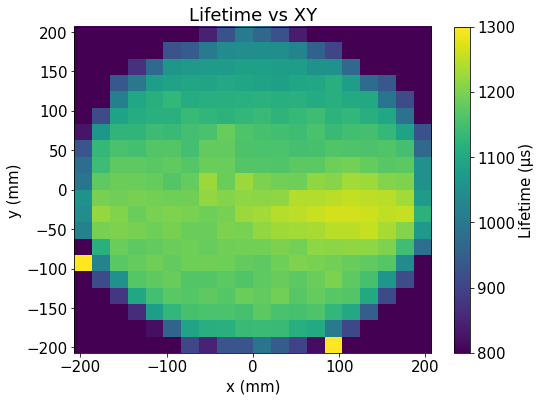

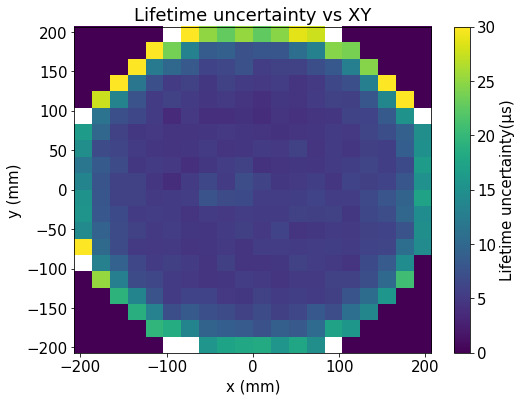

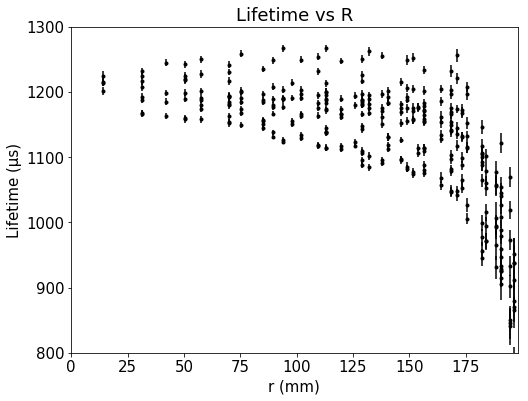

In [26]:
nx, ny = 20, 20
xbins  = np.linspace(*XYrange, nx+1)
ybins  = np.linspace(*XYrange, ny+1)
xybins = xbins, ybins

LT     = np.zeros((nx, ny))
u_LT   = np.zeros((nx, ny))

Z = full.Z  .values
X = full.X  .values
Y = full.Y  .values
E = full.S2e.values

plt.figure(figsize=(nx, ny))

for i in range(nx):
    for j in range(ny):
        sel_r = coref.in_range(E, *Erange_raw)\
              & coref.in_range(X, *xbins[i:i+2])\
              & coref.in_range(Y, *ybins[j:j+2])

        if np.count_nonzero(sel_r) < 100: continue
#        plt.subplot(ny, ny, i*nx+j+1)
#        n, x, y, _ = \
#        hist2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw), new_figure=False)
        n, x, y = \
        np.histogram2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw))
        x = shift_to_bin_centers(x)
        y = shift_to_bin_centers(y)
#        labels("Drift time (µs)", "S2 energy (pes)",
#               "X {:.0f} - {:.0f} mm; Y {:.0f} - {:.0f} mm".format(*xbins[i:i+2],
#                                                                   *ybins[j:j+2]))
        slice_max = np.argmax(n, axis=1)
        slice_ene = y[slice_max]
        slice_rms = [1.25*np.average((y-mean)**2, weights=w)**0.5 if np.any(w) else 0 for w, mean in zip(n, slice_ene)]

#        plt.errorbar(x, slice_ene, slice_rms, fmt="*k")

        f_low = fitf.fit(fitf.expo, x, slice_ene-slice_rms, (1e4, -500), fit_range=Zrange_LT)
        f_upp = fitf.fit(fitf.expo, x, slice_ene+slice_rms, (1e4, -500), fit_range=Zrange_LT)

#        plt.plot(x, f_low.fn(x), "r")
#        plt.plot(x, f_upp.fn(x), "r")

        low_cut = f_low.fn(Z)
        upp_cut = f_upp.fn(Z)
        sel_E   = coref.in_range(E, low_cut, upp_cut) # remove low and high E background

        x, y, u_y = fitf.profileX(Z[sel_r & sel_E], E[sel_r & sel_E], 100, xrange=Zrange, yrange=Erange_raw)
#        plt.errorbar(x, y, u_y, fmt="*m")

        seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
        f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

        LT  [i,j] = -f.values[1]
        u_LT[i,j] =  f.errors[1]
#plt.tight_layout()

_, cb = display_matrix(shift_to_bin_centers(xbins),
                       shift_to_bin_centers(ybins),
                       LT, vmin=800, vmax=1300)
cb.set_label("Lifetime (µs)")
labels("x (mm)", "y (mm)", "Lifetime vs XY")
save("LifetimevsXY")

_, cb = display_matrix(shift_to_bin_centers(xbins),
                       shift_to_bin_centers(ybins),
                       u_LT, vmin=0, vmax=30)
cb.set_label("Lifetime uncertainty(µs)")
labels("x (mm)", "y (mm)", "Lifetime uncertainty vs XY")
save("LifetimeUncertaintyvsXY")

plt.figure()
_x = np.repeat(shift_to_bin_centers(xbins), ny)
_y = np.tile  (shift_to_bin_centers(ybins), nx)
_r = (_x**2 + _y**2)**0.5
plt.errorbar(_r, LT.flatten(), u_LT.flatten(), fmt=".k")
plt.xlim(*Rrange)
plt.ylim(800, 1300)
labels("r (mm)", "Lifetime (µs)", "Lifetime vs R")
save("LifetimevsR")

# Correction by attachment

[  4.22883624e+07   1.23402854e+04   5.07551069e+02]


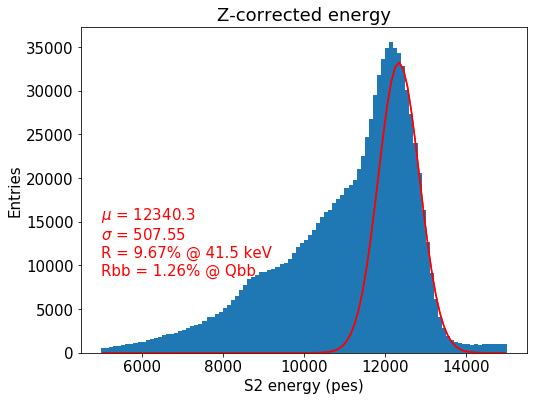

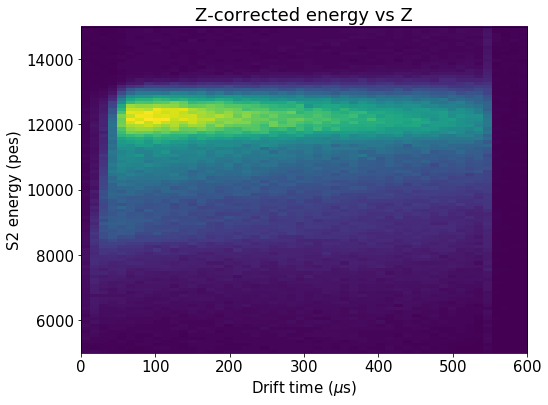

In [27]:
correction = Zcorr(full.Z.values, full.R.values) if LT_radial else\
             Zcorr(full.Z.values)
E_zcorr    = full.S2e.values * correction.value

y, x, _ = hist(E_zcorr, 100, range=Erange_zcorr)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3])
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(12400, 14000), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values),  fitOpt)
plt.text(Erange_zcorr[0], max(y)/4, gausstext(f.values, 41.5), color=fitOpt)

labels("S2 energy (pes)", "Entries", "Z-corrected energy")
save("EcorrZ")

hist2d(full.Z.values, E_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")
save("EcorrZvsZ")

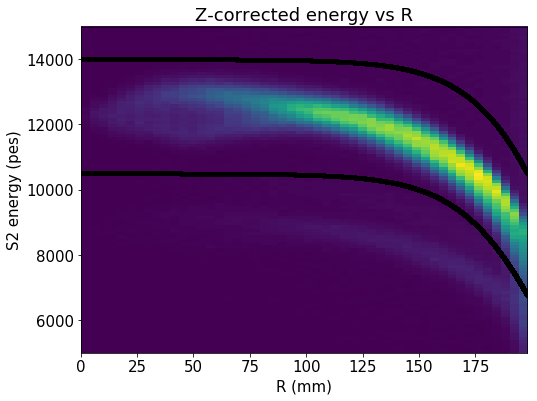

In [28]:
low_cut   = 10500 *(1/(1 + np.exp((full.R.values-210)/20)))
high_cut  = 14000 *(1/(1 + np.exp((full.R.values-220)/20)))
sel       = coref.in_range(full.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(full.R.values, E_zcorr, (50, 100), range=(Rrange, Erange_zcorr))
plt.plot(full.R.values,  low_cut, ".k")
plt.plot(full.R.values, high_cut, ".k")
labels("R (mm)", "S2 energy (pes)", "Z-corrected energy vs R")
save("EcorrZvsR")

# Tracking

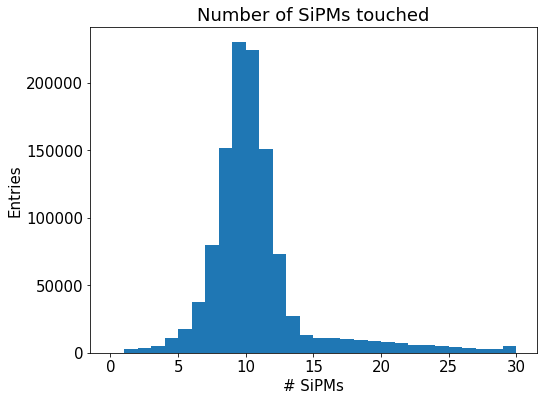

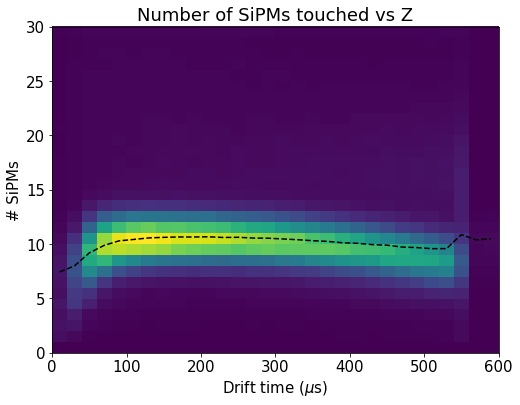

In [29]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# Kr distribution

In [30]:
sel     = coref.in_range(E_zcorr, low_cut, high_cut)
Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

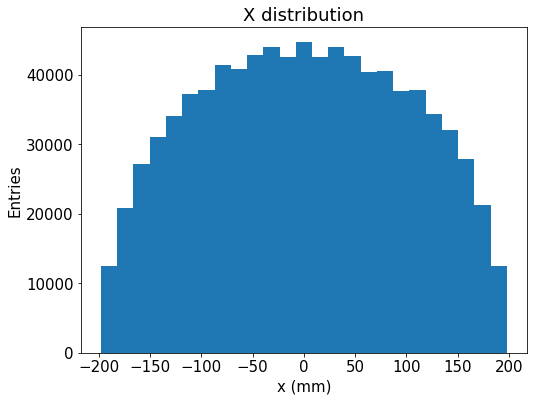

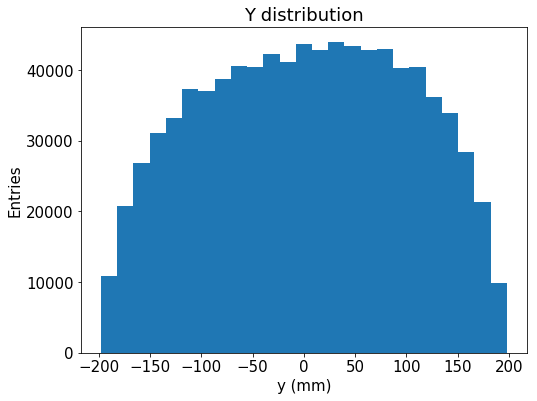

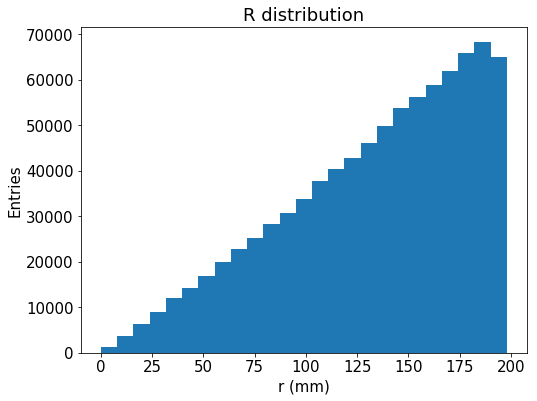

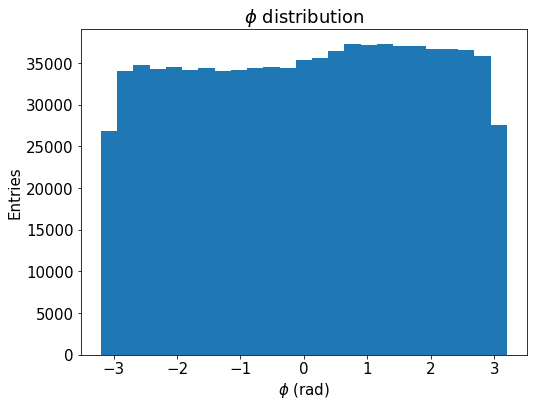

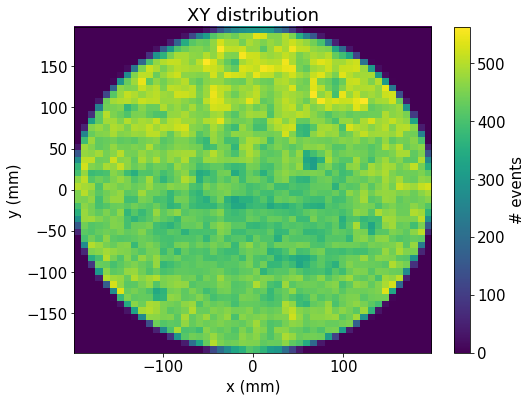

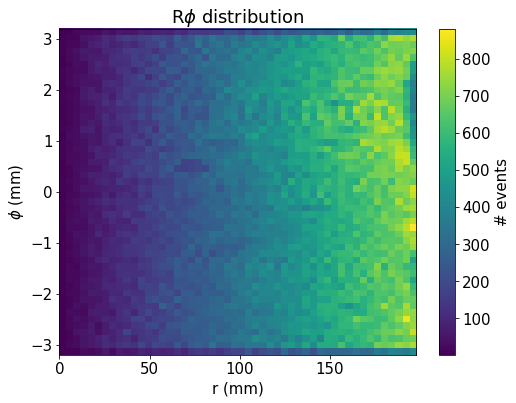

In [31]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

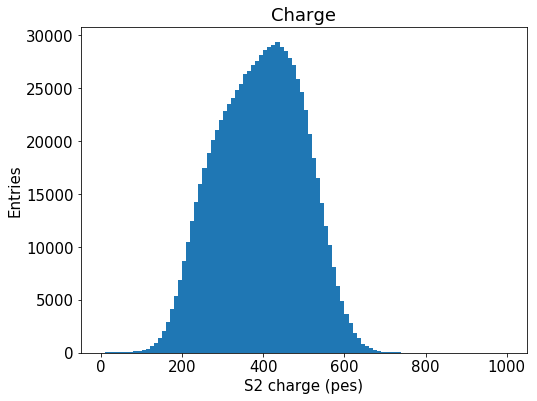

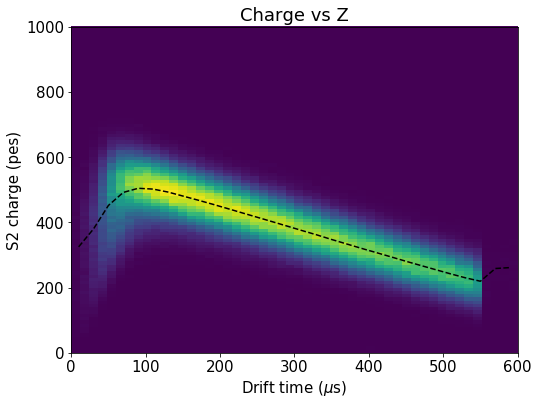

In [32]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QvsZ")

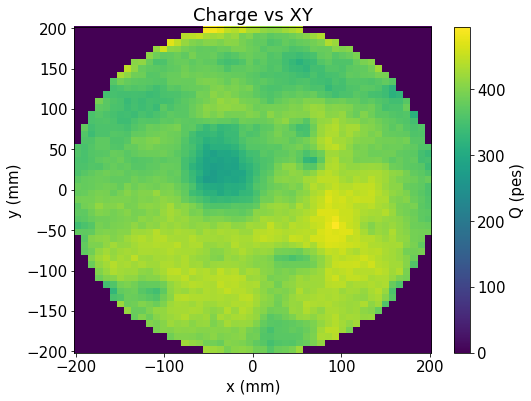

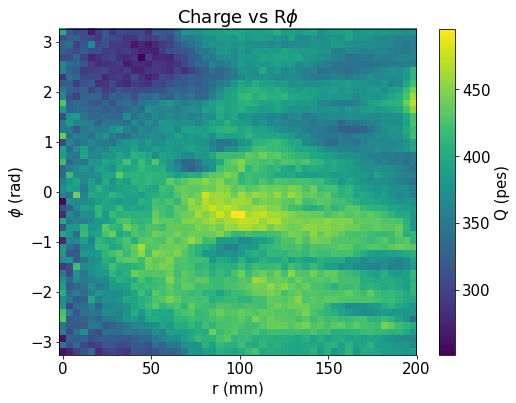

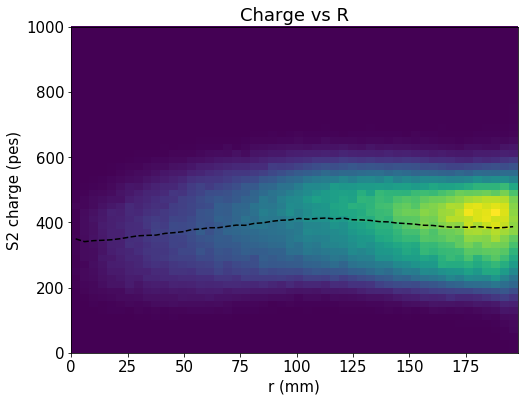

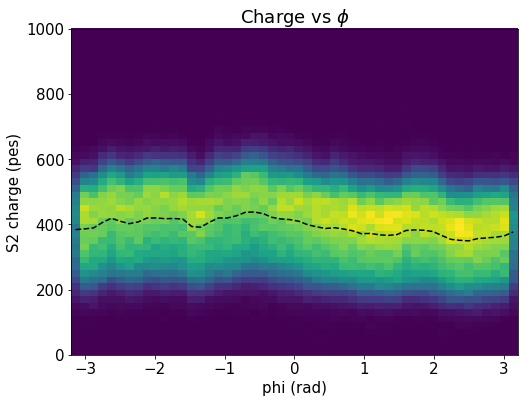

In [33]:
x, y, Q, u_Q = \
fitf.profileXY(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, Q)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

x, y, q, u_q = \
fitf.profileXY(Kr.R, Kr.Phi, Kr.S2q, nX, nY, Rrange, Prange)
_, cb = display_matrix(x, y, q)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

Reference energy = 12304.52915679022 pes


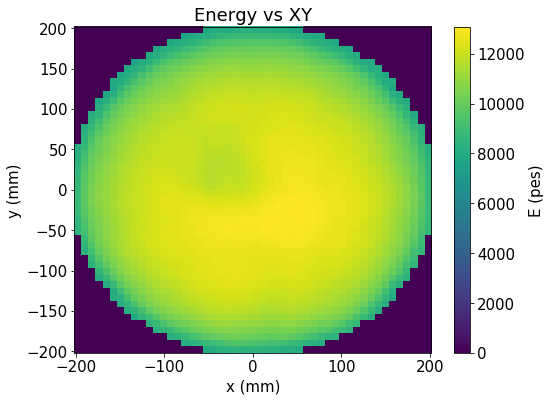

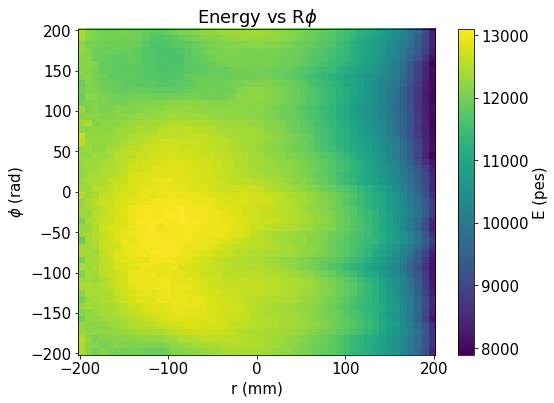

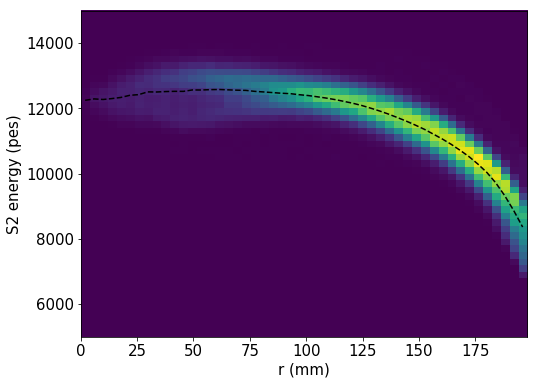

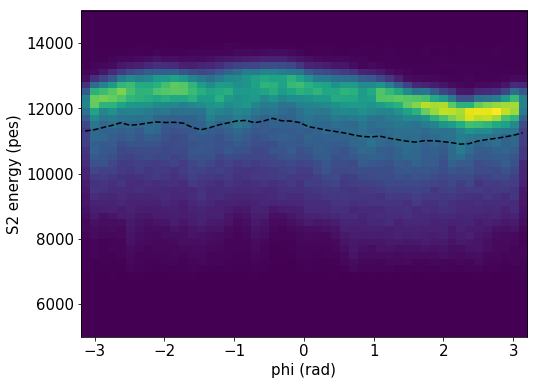

In [34]:
sel = sel_Kr = coref.in_range(Kr.Z.values, *Zrange_XY)

xc, yc, Ec, u_Ec = \
fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nX, nY, XYrange, XYrange)
_, cb = display_matrix(xc, yc, Ec)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EvsXY")

rc, pc, ec, u_ec = \
fitf.profileXY(Kr.R.values[sel], Kr.Phi.values[sel], E_zcorr[sel], nX, nY, Rrange, Prange)
_, cb = display_matrix(xc, yc, ec)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EvsRPhi")

hist2d(Kr.R.values[sel], E_zcorr[sel], (50, 50), range=(Rrange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.R.values[sel], E_zcorr[sel], 50, xrange=Rrange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(Kr.Phi.values[sel], E_zcorr[sel], (50, 50), range=(Prange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.Phi.values[sel], E_zcorr[sel], 50, xrange=Prange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

XYcorr    = corrf.Correction((xc, yc), Ec, u_Ec, "index", index=(nX//2, nY//2))
corr_file = tb.open_file(corr_filename, "w")
dstio.xy_writer(corr_file)(*XYcorr._xs, XYcorr._fs, XYcorr._us, nXY)
corr_file.close()
print("Reference energy = {} pes".format(Ec[tuple(np.argwhere(XYcorr._fs==1)[0])]))

#### Different pitches

Reference energy = 12283.247783989358 pes
Reference energy = 12304.52915679022 pes
Reference energy = 12249.590686472005 pes
Reference energy = 12315.273505213094 pes


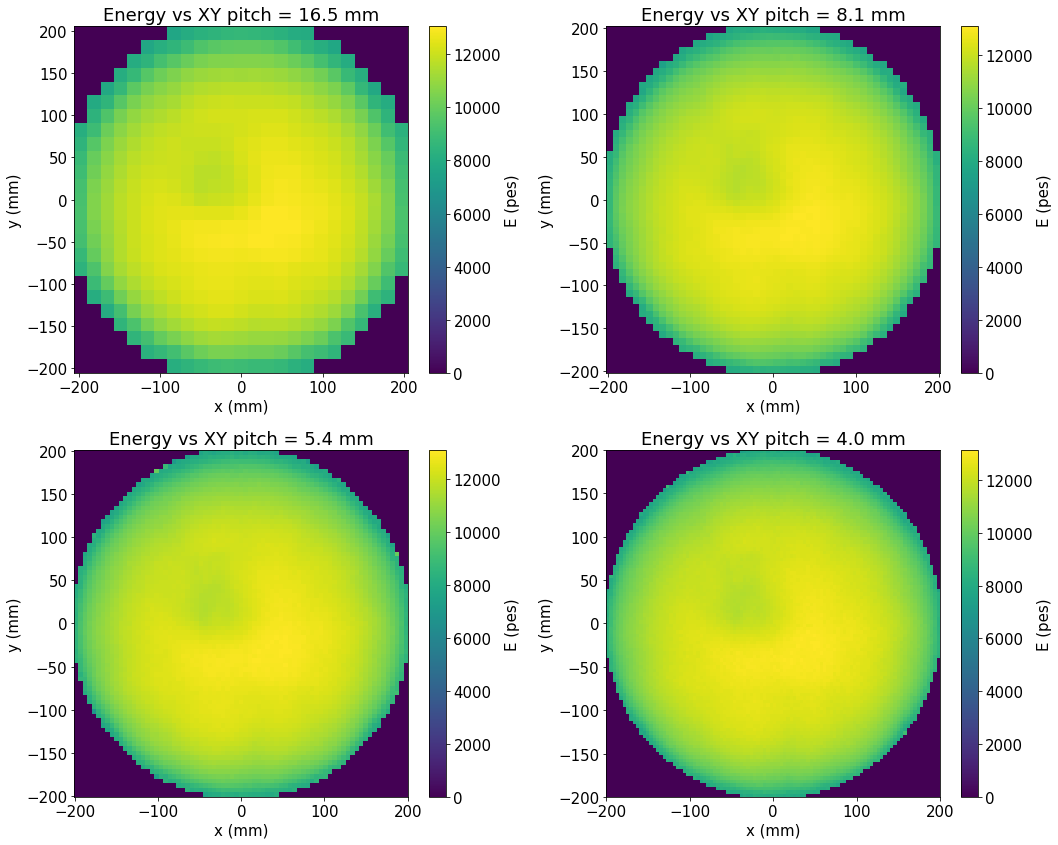

In [35]:
plt.figure(figsize=(15,12))
for i, (nx, ny) in enumerate(extra_pitches):
    plt.subplot(2, 2, i+1)
    xc_, yc_, Ec_, u_Ec_ = \
    fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nx, ny, XYrange, XYrange)
    _, cb = display_matrix(xc_, yc_, Ec_, new_figure=False)
    cb.set_label("E (pes)")
    pitch = np.diff(np.linspace(*XYrange, nx))[0]
    labels("x (mm)", "y (mm)", "Energy vs XY pitch = {:.1f} mm".format(pitch))
    nXY_ = np.histogram2d(Kr.X.values[sel],
                          Kr.Y.values[sel],
                          (nx, ny),
                          (XYrange, XYrange))[0]
    
    XYcorr_        = corrf.Correction((xc_, yc_), Ec_, u_Ec_, "index", index=(nx//2, ny//2))
    corr_filename_ = corr_filename.replace(".h5", "_{:.1f}mm.h5".format(pitch))
    corr_file_     = tb.open_file(corr_filename_, "w")
    dstio.xy_writer(corr_file_)(*XYcorr_._xs, XYcorr_._fs, XYcorr_._us, nXY_)
    corr_file_.close()
    print("Reference energy = {} pes".format(Ec_[tuple(np.argwhere(XYcorr_._fs==1)[0])]))
plt.tight_layout()

# Correction maps

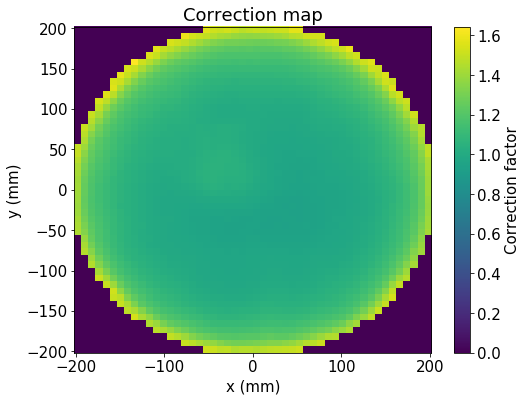

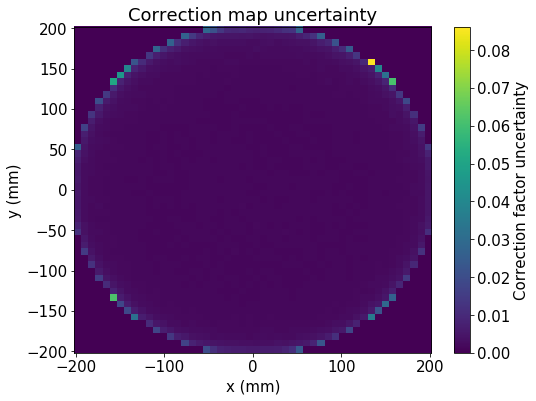

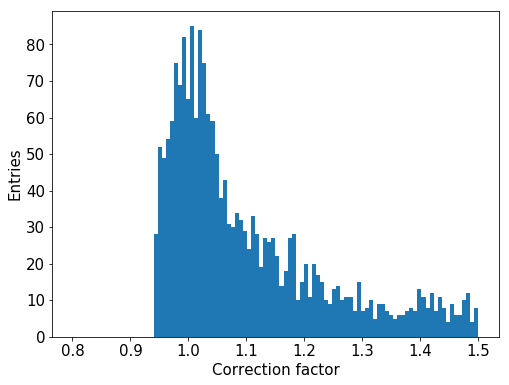

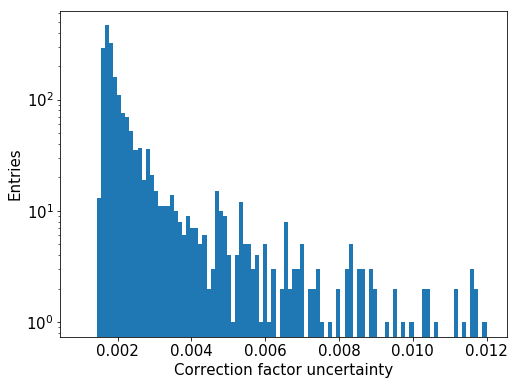

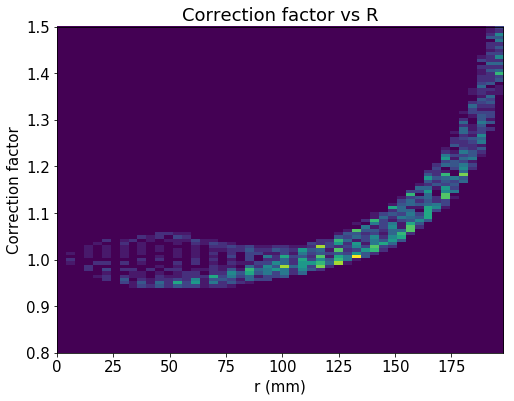

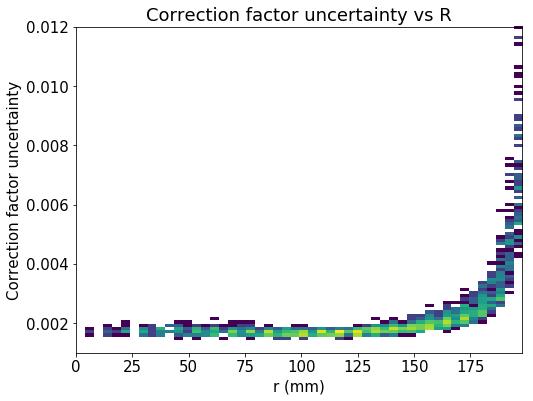

In [36]:
_r = (np.repeat(xc, yc.size)**2 +
      np.tile  (yc, xc.size)**2)**0.5
_f = XYcorr._fs.flatten()
_u = XYcorr._us.flatten()

_, cb = display_matrix(xc, yc, _f)
labels("x (mm)", "y (mm)", "Correction map")
cb.set_label("Correction factor")
save("CorrectionMap")

_, cb = display_matrix(xc, yc, _u)
labels("x (mm)", "y (mm)", "Correction map uncertainty")
cb.set_label("Correction factor uncertainty")
save("CorrectionMapUncertainty")

hist(_f, 100, Frange)
labels("Correction factor", "Entries")
save("CorrectionMapHist")

hist(_u[_u > 0], 100, Urange)
plt.yscale("log")
labels("Correction factor uncertainty", "Entries")
save("CorrectionMapUncertaintyHist")

hist2d(_r, _f, (nR, 100), (Rrange, Frange))
labels("r (mm)", "Correction factor", "Correction factor vs R")
save("CorrectionFactorVsR")

hist2d(_r, _u, (nR, 100), (Rrange, Urange), norm=LogNorm())
labels("r (mm)", "Correction factor uncertainty", "Correction factor uncertainty vs R")
save("CorrectionFactorUncertaintyVsR")

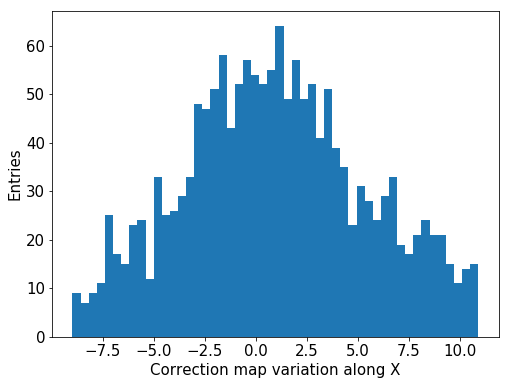

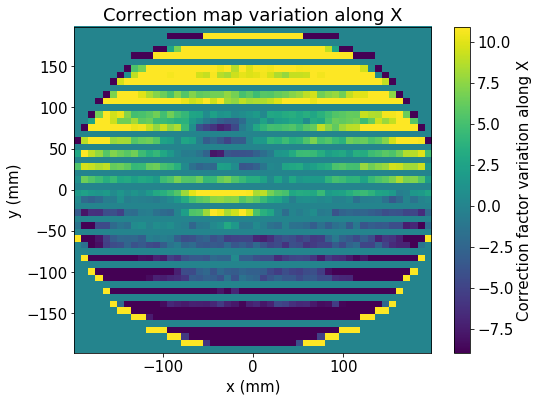

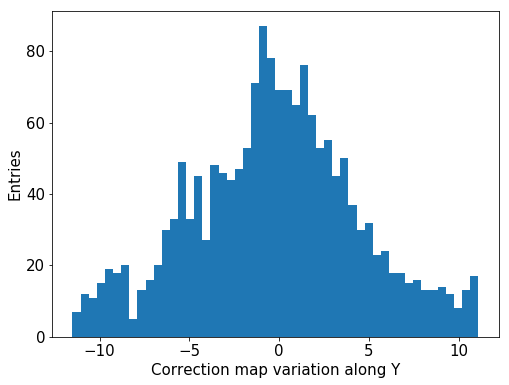

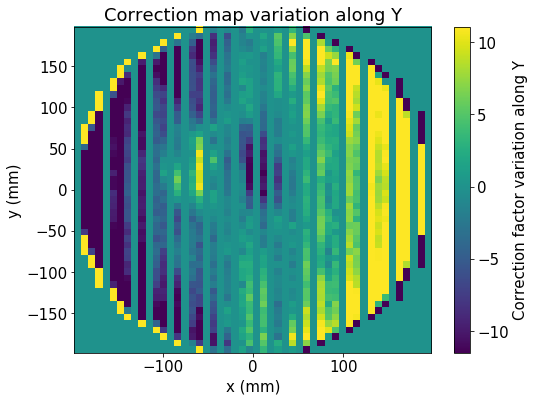

In [37]:
_x  = np.repeat(xc                      , yc.size - 1)
_y  = np.tile  (shift_to_bin_centers(yc), xc.size    )
_fx = np.diff(XYcorr._fs, axis=1) / (XYcorr._us[:, :-1]**2 + XYcorr._us[:, 1:]**2)**0.5
sel = ~np.isnan(_fx).flatten()

_min = np.nanmean(_fx) - .4*np.nanstd(_fx)
_max = np.nanmean(_fx) + .4*np.nanstd(_fx)

hist(_fx.flatten(), 50,  (_min, _max))
labels("Correction map variation along X", "Entries")

hist2d(_x[sel], _y[sel], (nX, nY), (XYrange, XYrange), weights=_fx.flatten()[sel], vmin=_min, vmax=_max)
labels("x (mm)", "y (mm)", "Correction map variation along X")
plt.colorbar().set_label("Correction factor variation along X")
save("CorrectionMapVariationX")

_x  = np.repeat(shift_to_bin_centers(xc), yc.size    )
_y  = np.tile  (yc                      , xc.size - 1)
_fy = np.diff(XYcorr._fs, axis=0) / (XYcorr._us[:-1, :]**2 + XYcorr._us[1:, :]**2)**0.5
sel = ~np.isnan(_fy).flatten()

_min = np.nanmean(_fy) - .4*np.nanstd(_fy)
_max = np.nanmean(_fy) + .4*np.nanstd(_fy)

hist(_fy.flatten(), 50,  (_min, _max))
labels("Correction map variation along Y", "Entries")
#plt.yscale("log")

hist2d(_x[sel], _y[sel], (nX, nY), (XYrange, XYrange), weights=_fy.flatten()[sel], vmin=_min, vmax=_max)
labels("x (mm)", "y (mm)", "Correction map variation along Y")
plt.colorbar().set_label("Correction factor variation along Y")
save("CorrectionMapVariationX")

# Charge/Energy ratio

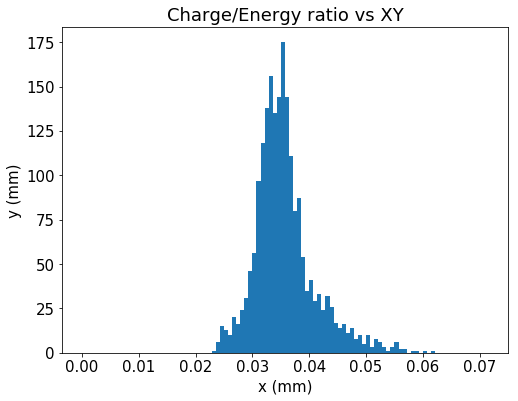

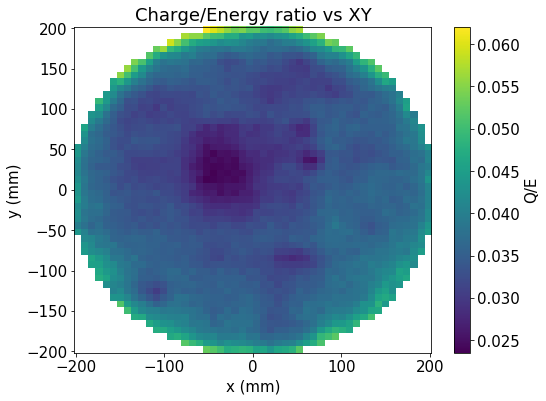

In [38]:
ratio = Q/Ec

hist(ratio.flatten(), 100, QErange)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

_, cb = display_matrix(xc, yc, ratio)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

# Correction by position

Fit values: [  5.23868743e+07   1.23083261e+04   3.06138612e+02]
Fit errors: [  1.13539063e+06   6.72545632e+00   5.42122180e+00]
Chi2      : 289289.377908


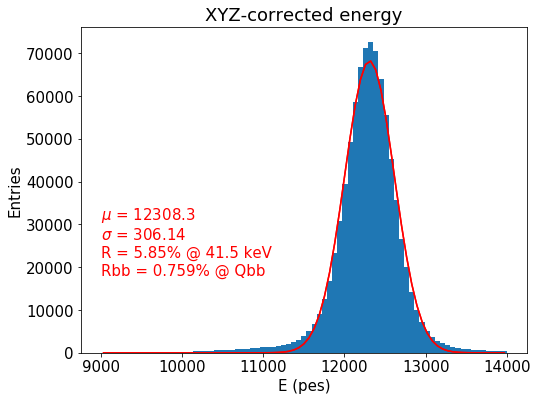

In [39]:
E_xyzcorr = E_zcorr * XYcorr(Kr.X.values, Kr.Y.values).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyzcorr, bins)

fun  = fitf.gauss
ndata = E_xyzcorr.size
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values),  fitOpt)
plt.text(Erange_xycorr[0], 1*max(y)/4, gausstext(f.values, 41.5), color=fitOpt)
labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

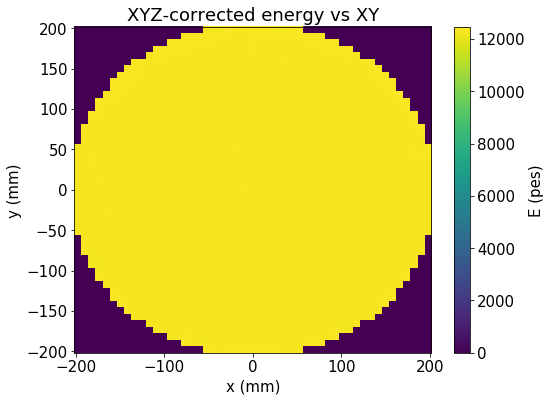

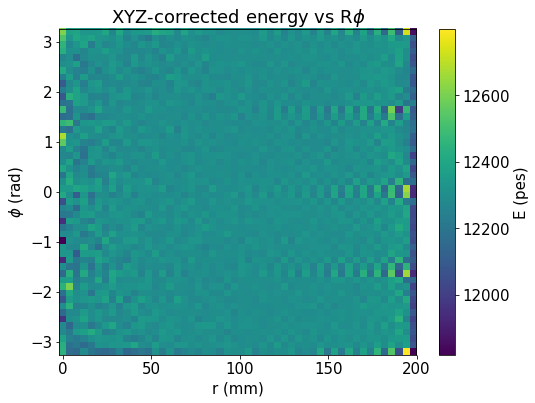

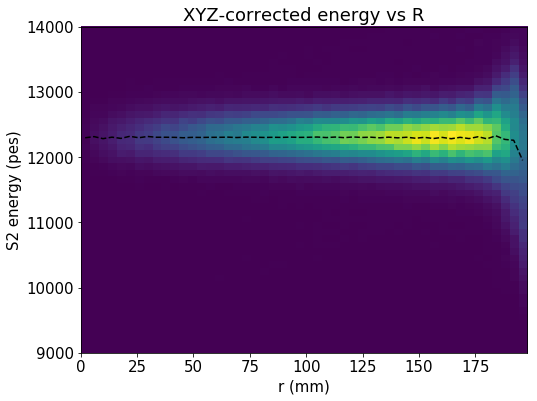

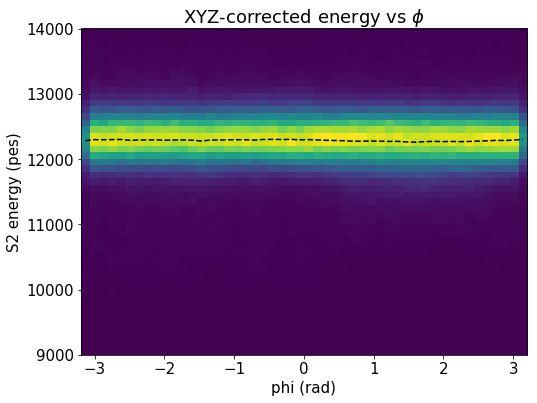

In [40]:
x, y, e, u_e = fitf.profileXY(Kr.X.values, Kr.Y.values, E_xyzcorr, 50, 50, XYrange, XYrange)
_, cb = display_matrix(x, y, e)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "XYZ-corrected energy vs XY")
save("EcorrZXYvsXY")

x, y, e, u_e = fitf.profileXY(Kr.R.values, Kr.Phi.values, E_xyzcorr, 50, 50, Rrange, Prange)
_, cb = display_matrix(x, y, e)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "XYZ-corrected energy vs R$\phi$")
save("EcorrZXYvsRPhi")

hist2d(Kr.R.values, E_xyzcorr, (50, 50), range=(Rrange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.R.values, E_xyzcorr, 50, Rrange, Erange_xycorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)", "XYZ-corrected energy vs R")
save("EcorrZXYvsR")

hist2d(Kr.Phi.values, E_xyzcorr, (50, 50), range=(Prange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.Phi.values, E_xyzcorr, 50, xrange=Prange, yrange=Erange_xycorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)", "XYZ-corrected energy vs $\phi$")
save("EcorrZXYvsPhi")

# Correction by time

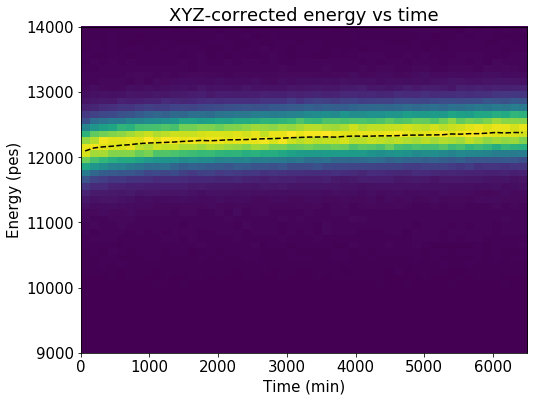

In [41]:
T      = (Kr.time.values - np.min(Kr.time.values))/60
Trange = 0, np.max(T)

hist2d(T, E_xyzcorr, (50, 50), range=(Trange, Erange_xycorr))

x, y, u_y = fitf.profileX(T, E_xyzcorr, 50, Trange, Erange_xycorr)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZ-corrected energy vs time")
save("EcorrZXYvsT")

Tcorr = corrf.Correction((x,), y, u_y, "max")

Fit values: [  5.23666062e+07   1.23987813e+04   3.01053256e+02]
Fit errors: [  1.22458944e+06   7.07838997e+00   5.65075391e+00]
Chi2      : 133382.609232


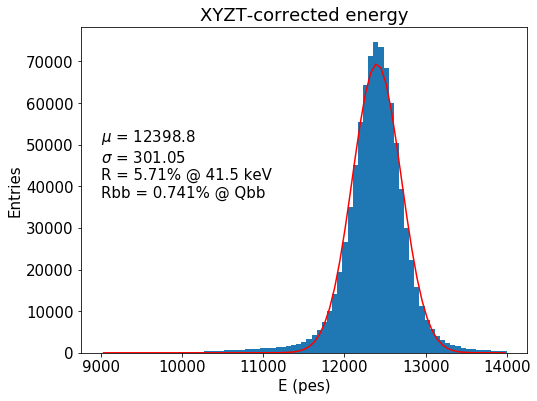

In [42]:
E_xyztcorr = E_xyzcorr * Tcorr(T).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr, bins)

fun  = fitf.gauss
ndata = E_xyztcorr.size
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))
labels("E (pes)", "Entries", "XYZT-corrected energy")
save("EcorrZXYT")

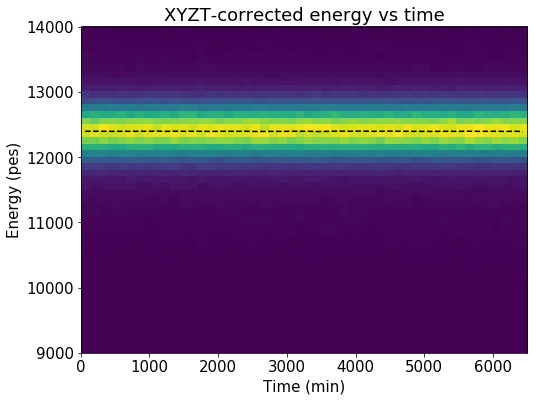

In [43]:
hist2d(T, E_xyztcorr, (50, 50), range=(Trange, Erange_xycorr))
x, y, _ = fitf.profileX(T, E_xyztcorr, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZT-corrected energy vs time")
save("EcorrZXYTvsT")

# Resolution dependance

Fit values: [  1.31032885e+07   1.24082937e+04   2.54688196e+02]
Fit errors: [  1.93097748e+05   3.75625584e+00   2.83371163e+00]
Chi2      : 696048.452759


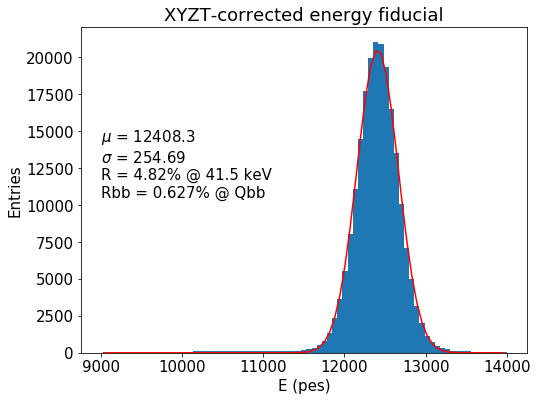

In [44]:
sel_r  = coref.in_range(Kr.R.values, 0, 100)

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_r], bins)

fun   =  fitf.gauss
ndata = np.count_nonzero(sel_r)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial")
save("EcorrZXYT_fiducial")

Fit values: [  8.04715394e+06   1.24391537e+04   2.68779237e+02]
Fit errors: [  2.52573265e+05   8.49932178e+00   6.64607769e+00]
Chi2      : 152089.427344


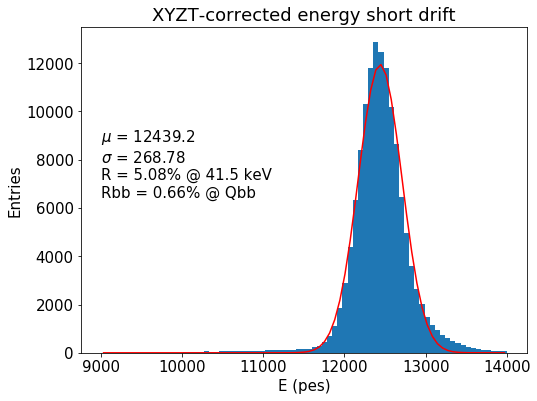

In [45]:
sel_z  = coref.in_range(Kr.Z.values, 0, 100)

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_z], bins)

fun   = fitf.gauss
ndata = np.count_nonzero(sel_z)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy short drift")
save("EcorrZXYT_short_drift")

Fit values: [  1.67564675e+06   1.23822568e+04   2.11606822e+02]
Fit errors: [  2.20726840e+04   2.78841278e+00   2.04320115e+00]
Chi2      : 520536035.635


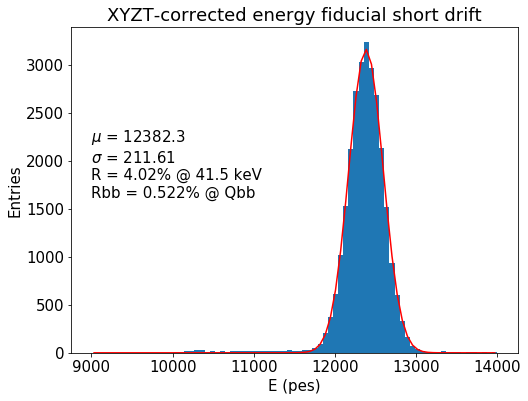

In [46]:
sel_zr = sel_z & sel_r

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_zr], bins)

fun   = fitf.gauss
ndata = np.count_nonzero(sel_zr)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial short drift")
save("EcorrZXYT_fiducial_short_drift")

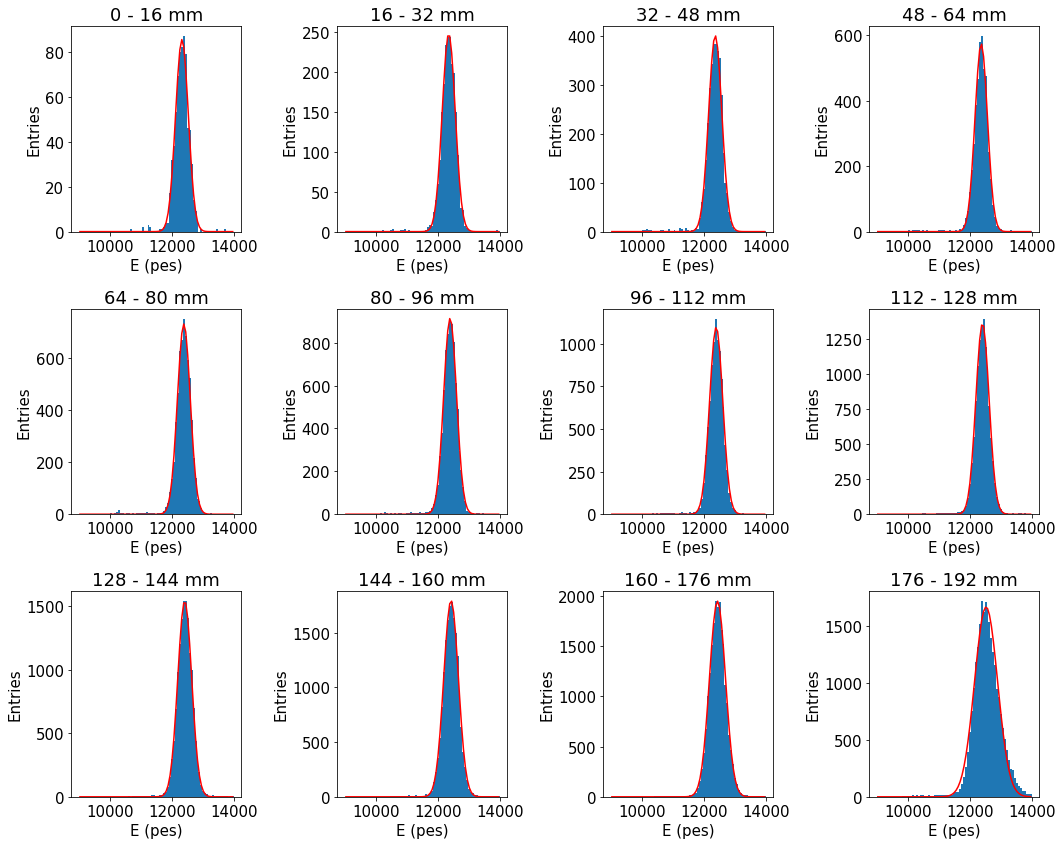

In [47]:
#Rbins = [0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190]
Rbins = np.linspace(0, 192, 13)
nbins = len(Rbins) - 1
r     = shift_to_bin_centers(Rbins)
dr    = 0.5 * np.diff       (Rbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 4, i+1)

    sel = coref.in_range(Kr.R.values, *Rbins[i:i+2]) & sel_z

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(E_xyztcorr[sel], bins, new_figure=False)

    fun   = fitf.gauss
    ndata = np.count_nonzero(sel)
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03
    
    f = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp))
    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Rbins[i:i+2]))

    reso = resolution(f.values, f.errors, E_from=41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
plt.tight_layout()
save("EcorrZXYT_Rslices")

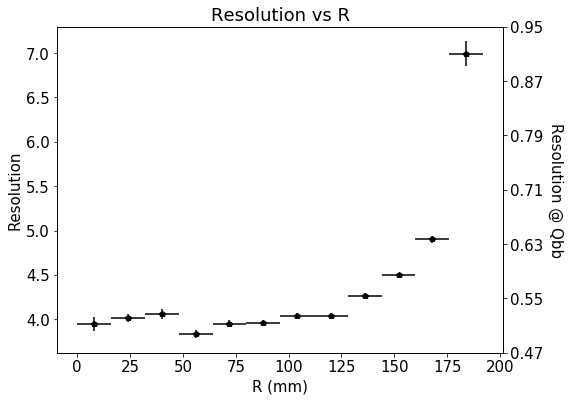

In [48]:
plt.errorbar(r, R, u_R, dr, "kp")
labels("R (mm)", "Resolution", "Resolution vs R")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionvsR")

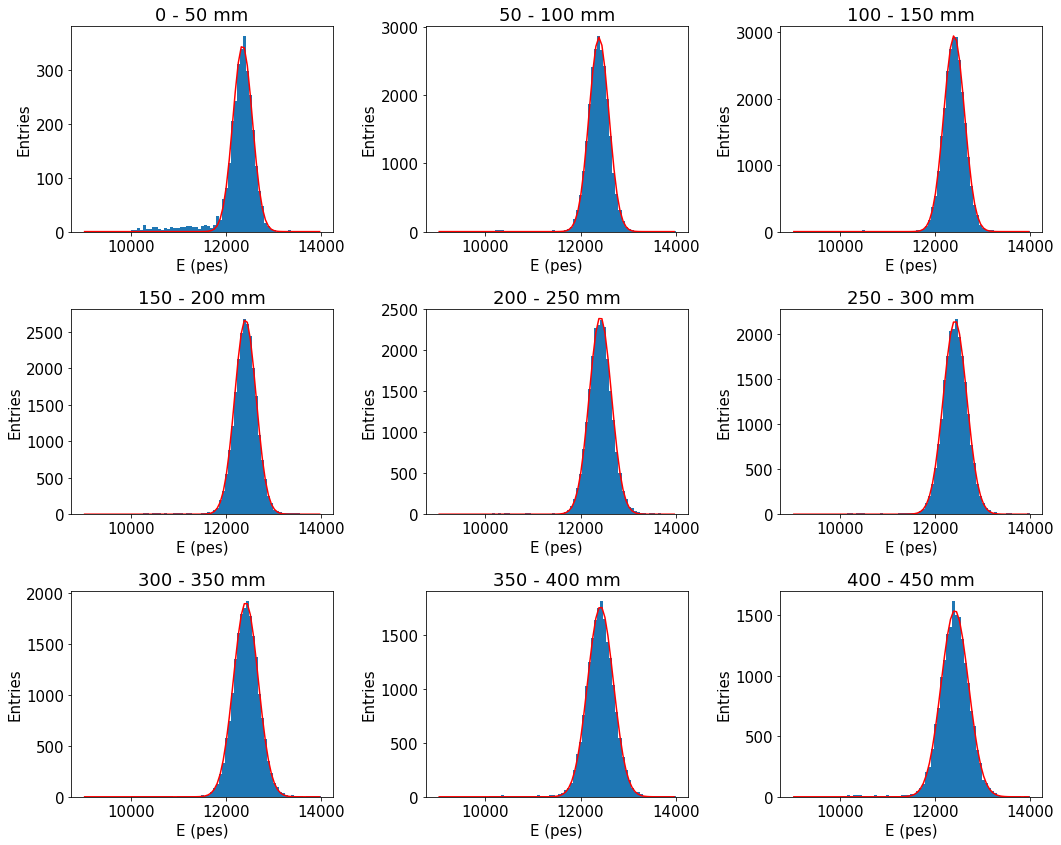

In [49]:
Zbins = np.linspace(0, 450, 10)
nbins = len(Zbins) - 1
z     = shift_to_bin_centers(Zbins)
dz    = 0.5 * np.diff       (Zbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 3, i+1)
    
    sel = coref.in_range(Kr.Z.values, *Zbins[i:i+2]) & sel_r

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(E_xyztcorr[sel], bins, new_figure=False)

    fun   = fitf.gauss
    ndata = np.count_nonzero(sel)
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03
    
    f = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp))
    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Zbins[i:i+2]))

    reso = resolution(f.values, f.errors, E_from=41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
plt.tight_layout()
save("EcorrZXYT_Zslices")

Resolutions [ 0.50318638  0.51510092  0.53521274  0.55163785  0.57294673  0.60687422
  0.63911676  0.66415256  0.70953934]


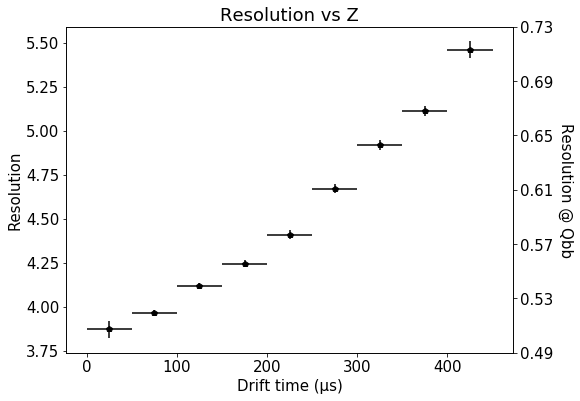

In [50]:
plt.errorbar(z, R, u_R, dz, "kp")
labels("Drift time (µs)", "Resolution", "Resolution vs Z")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
print("Resolutions", Rbb)
save("ResolutionvsZ")

# Apply map to a orthogonal dataset

Fit values: [  5.07589496e+07   1.23973991e+04   2.89162620e+02   9.44727253e+02]
Fit errors: [  7.00994909e+05   3.98572748e+00   3.37774110e+00   1.00181898e+02]
Chi2      : 170.838203661


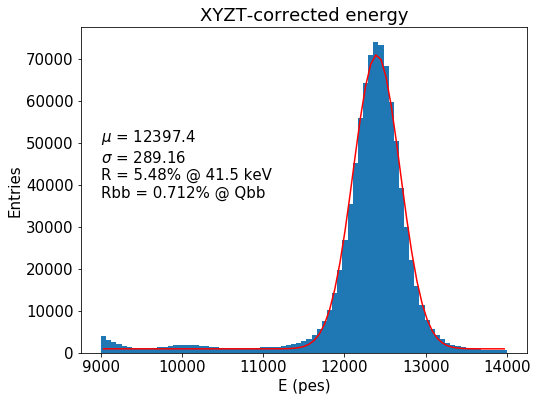

In [51]:
if split_sample:
    test_T     = (test_data.time.values - np.min(full_data.time.values))/60
    correction = Zcorr(test_data.Z.values, test_data.R.values) if LT_radial else\
                 Zcorr(test_data.Z.values)
    Etest_corr = test_data.S2e.values * correction.value\
                                      * XYcorr(test_data.X.values,
                                               test_data.Y.values).value\
                                      * Tcorr(test_T).value

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(Etest_corr, bins, new_figure=False)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + args[3]
    ndata = Etest_corr.size
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02, 1e2
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01, 0e2
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03, 1e4
    
    f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
    print("Fit values:", f.values)
    print("Fit errors:", f.errors)
    print("Chi2      :", f.chi2)

    plt.plot(x, f.fn(x), fitOpt)
    plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

    labels("E (pes)", "Entries", "XYZT-corrected energy")
    save("Etest")